In [9]:
%%bash
pip install -qU openai tiktoken pinecone gradio tavily-python
pip install -qU arize-phoenix-otel arize-phoenix openinference-instrumentation-langchain
pip install -qU langchain langchain-community langchain-pinecone langchain_openai

# Set up Pinecone RAG tool

In [8]:
import os
from pinecone import Pinecone
from langchain.chains import RetrievalQA
from langchain_openai import OpenAIEmbeddings
from langchain_openai import OpenAI
from langchain_pinecone import PineconeVectorStore
from langchain_core.tools import tool
import gradio as gr

In [13]:
import dotenv
dotenv.load_dotenv()

True

In [16]:
embeddings = OpenAIEmbeddings()
pinecone = Pinecone(api_key=os.environ["PINECONE_KEY"], environment=os.environ["PINECONE_ENV"])
index = pinecone.Index(os.environ["PINECONE_INDEX"])
vector_store = PineconeVectorStore(index, embeddings, "text")

qa = RetrievalQA.from_chain_type(llm=OpenAI(temperature=0), chain_type="stuff", retriever=vector_store.as_retriever())

@tool
def generate_response_phoenix(message, history):
    """Queries the Phoenix docs and returns a response.

    Args:
        message (str): The message to query the Phoenix docs with.
        history (list): The history of the conversation.

    Returns:
        str: The response from the Phoenix docs.
    """
    response = qa.invoke(message)
    return response.get("result")

INFO:pinecone_plugin_interface.logging:Discovering subpackages in _NamespacePath(['/Users/jgilhuly/Documents/dev/GitHub/phoenix/.venv/lib/python3.11/site-packages/pinecone_plugins'])
INFO:pinecone_plugin_interface.logging:Looking for plugins in pinecone_plugins.inference
INFO:pinecone_plugin_interface.logging:Installing plugin inference into Pinecone


In [11]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import AnyMessage, add_messages

class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

### Tool utility functions

In [19]:
from langchain_core.messages import ToolMessage
from langchain_core.runnables import RunnableLambda

from langgraph.prebuilt import ToolNode


def handle_tool_error(state) -> dict:
    error = state.get("error")
    tool_calls = state["messages"][-1].tool_calls
    return {
        "messages": [
            ToolMessage(
                content=f"Error: {repr(error)}\n please fix your mistakes.",
                tool_call_id=tc["id"],
            )
            for tc in tool_calls
        ]
    }


def create_tool_node_with_fallback(tools: list) -> dict:
    return ToolNode(tools).with_fallbacks(
        [RunnableLambda(handle_tool_error)], exception_key="error"
    )


def _print_event(event: dict, _printed: set, max_length=1500):
    current_state = event.get("dialog_state")
    if current_state:
        print("Currently in: ", current_state[-1])
    message = event.get("messages")
    if message:
        if isinstance(message, list):
            message = message[-1]
        if message.id not in _printed:
            msg_repr = message.pretty_repr(html=True)
            if len(msg_repr) > max_length:
                msg_repr = msg_repr[:max_length] + " ... (truncated)"
            print(msg_repr)
            _printed.add(message.id)

### Define the assistant

In [17]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import Runnable, RunnableConfig
from langchain_community.tools.tavily_search import TavilySearchResults
from datetime import datetime


class Assistant:
    def __init__(self, runnable: Runnable):
        self.runnable = runnable

    def __call__(self, state: State, config: RunnableConfig):
        while True:
            state = {**state}
            result = self.runnable.invoke(state)
            # If the LLM happens to return an empty response, we will re-prompt it
            # for an actual response.
            if not result.tool_calls and (
                not result.content
                or isinstance(result.content, list)
                and not result.content[0].get("text")
            ):
                messages = state["messages"] + [("user", "Respond with a real output.")]
                state = {**state, "messages": messages}
            else:
                break
        return {"messages": result}


from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o")

primary_assistant_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful customer support assistant for Phoenix "
            " Use the provided tools to answer questions about Phoenix. "
            " When searching, be persistent. Expand your query bounds if the first search returns no results. "
            " If a search comes up empty, expand your search before giving up."
            "\nCurrent time: {time}.",
        ),
        ("placeholder", "{messages}"),
    ]
).partial(time=datetime.now())

tools = [
    TavilySearchResults(max_results=1),
    generate_response_phoenix
    
]
assistant_runnable = primary_assistant_prompt | llm.bind_tools(tools)

### Build the graph

In [20]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import tools_condition

builder = StateGraph(State)

# Define nodes: these do the work
builder.add_node("assistant", Assistant(assistant_runnable))
builder.add_node("tools", create_tool_node_with_fallback(tools))
# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    tools_condition,
)
builder.add_edge("tools", "assistant")

# The checkpointer lets the graph persist its state
# this is a complete memory for the entire graph.
memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

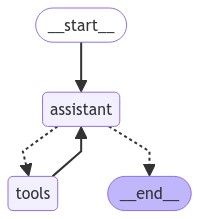

In [22]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

### Wrap the graph in a function for our Gradio interface

In [37]:
def call_agent(message, history):
    import uuid

    thread_id = str(uuid.uuid4())

    config = {
        "configurable": {
            # Checkpoints are accessed by thread_id
            "thread_id": thread_id,
        }
    }

    event = graph.invoke(
        {"messages": ("user", message)}, config, stream_mode="values"
    )
    
    return event.get("messages")[-1].content

## Set up Gradio interface

In [38]:
iface = gr.ChatInterface(
    call_agent,
    title="Phoenix Docs Query Bot",
    description="Ask me anything about Phoenix documentation!",
)

INFO:httpx:HTTP Request: GET https://api.gradio.app/pkg-version "HTTP/1.1 200 OK"


In [39]:
iface.launch()

INFO:httpx:HTTP Request: GET http://127.0.0.1:7865/startup-events "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: HEAD http://127.0.0.1:7865/ "HTTP/1.1 200 OK"


Running on local URL:  http://127.0.0.1:7865

To create a public link, set `share=True` in `launch()`.


ERROR:openinference.instrumentation.langchain._tracer:Failed to get attribute.
Traceback (most recent call last):
  File "/Users/jgilhuly/Documents/dev/GitHub/phoenix/.venv/lib/python3.11/site-packages/openinference/instrumentation/langchain/_tracer.py", line 279, in wrapper
    yield from wrapped(*args, **kwargs)
  File "/Users/jgilhuly/Documents/dev/GitHub/phoenix/.venv/lib/python3.11/site-packages/openinference/instrumentation/langchain/_tracer.py", line 379, in _input_messages
    raise ValueError(f"failed to parse messages of type {type(first_messages)}")
ValueError: failed to parse messages of type <class 'str'>
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
ERROR:openinference.instrumentation.langchain._tracer:Failed to get attribute.
Traceback (most recent call last):
  File "/Users/jgilhuly/Documents/dev/GitHub/phoenix/.venv/lib/python3.11/site-packages/openinference/instrumentation/langchain/_tracer.py", line 279, in wrapper
    yie

# Add tracing

In [ ]:
from phoenix.otel import register

os.environ["OTEL_EXPORTER_OTLP_HEADERS"] = f"api_key={os.environ['PHOENIX_API_KEY']}"
os.environ["PHOENIX_CLIENT_HEADERS"] = f"api_key={os.environ['PHOENIX_API_KEY']}"
os.environ["PHOENIX_COLLECTOR_ENDPOINT"] = "https://app.phoenix.arize.com"

tracer_provider = register(project_name="pinecone-rag-agent")

from openinference.instrumentation.langchain import LangChainInstrumentor
LangChainInstrumentor().instrument(tracer_provider=tracer_provider, skip_dep_check=True)

# Evaluate our chatbot

In [43]:
from phoenix.session.evaluation import get_qa_with_reference
import phoenix as px

qa_with_reference_df = get_qa_with_reference(px.Client(), project_name="pinecone-rag-agent")
qa_with_reference_df

INFO:httpx:HTTP Request: GET https://app.phoenix.arize.com/arize_phoenix_version "HTTP/1.1 200 OK"
/Users/jgilhuly/Documents/dev/GitHub/phoenix/.venv/lib/python3.11/site-packages/phoenix/utilities/client.py:25: UserWarning: The Phoenix server has an unknown version and may have compatibility issues.
  warnings.warn(
INFO:httpx:HTTP Request: POST https://app.phoenix.arize.com/v1/spans?project_name=pinecone-rag-agent&project-name=pinecone-rag-agent "HTTP/1.1 200 OK"
/Users/jgilhuly/Documents/dev/GitHub/phoenix/.venv/lib/python3.11/site-packages/phoenix/utilities/client.py:45: UserWarning: The Phoenix server (4.22.1) and client (4.30.0) versions are mismatched and may have compatibility issues.
  warnings.warn(


,input,output,reference
context.span_id,,,
e00d7f1ed0412769,Tell me about Phoenix evals,Phoenix evals are a module in the Phoenix pla...,text: How to: Evals | Phoenix\nPhoenix Evaluat...
c2aab92e9fc8c5cb,"{""messages"": [""user"", ""Tell me about the phoen...","{""messages"": [""content='Tell me about the phoe...",text: Arize | Phoenix\nPhoenix works hand-in-h...
3613b2e9da333c39,"{""messages"": [""user"", ""Tell me about instrumen...","{""messages"": [""content='Tell me about instrume...",text: Manual Instrumentation | Phoenix\n\nurl:...
074164f858454e4f,"{""messages"": [""user"", ""tell me about phoenix e...","{""messages"": [""content='tell me about phoenix ...",text: How to: Evals | Phoenix\nPhoenix Evaluat...
f48ffde86dd3b37d,"{""messages"": [""user"", ""tell me about instrumen...","{""messages"": [""content='tell me about instrume...",text: Manual Instrumentation | Phoenix\n\nurl:...


In [44]:
from phoenix.evals import (
    HallucinationEvaluator,
    OpenAIModel,
    QAEvaluator,
    run_evals,
)
import nest_asyncio
nest_asyncio.apply()

qa_evaluator = QAEvaluator(OpenAIModel(model="gpt-4-turbo-preview"))
hallucination_evaluator = HallucinationEvaluator(OpenAIModel(model="gpt-4-turbo-preview"))

qa_correctness_eval_df, hallucination_eval_df = run_evals(
    evaluators=[qa_evaluator, hallucination_evaluator],
    dataframe=qa_with_reference_df,
    provide_explanation=True,
    concurrency=20,
)

run_evals |          | 0/10 (0.0%) | ⏳ 00:00<? | ?it/s

0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/c

In [45]:
from phoenix.trace import SpanEvaluations

px.Client().log_evaluations(
    SpanEvaluations(dataframe=qa_correctness_eval_df, eval_name="Q&A Correctness"),
    SpanEvaluations(dataframe=hallucination_eval_df, eval_name="Hallucination"),
    project_name="pinecone-rag-agent"
)

INFO:httpx:HTTP Request: GET https://app.phoenix.arize.com/arize_phoenix_version "HTTP/1.1 200 OK"
/Users/jgilhuly/Documents/dev/GitHub/phoenix/.venv/lib/python3.11/site-packages/phoenix/utilities/client.py:25: UserWarning: The Phoenix server has an unknown version and may have compatibility issues.
  warnings.warn(
INFO:httpx:HTTP Request: POST https://app.phoenix.arize.com/v1/evaluations "HTTP/1.1 200 OK"
/Users/jgilhuly/Documents/dev/GitHub/phoenix/.venv/lib/python3.11/site-packages/phoenix/utilities/client.py:45: UserWarning: The Phoenix server (4.22.1) and client (4.30.0) versions are mismatched and may have compatibility issues.
  warnings.warn(
INFO:httpx:HTTP Request: POST https://app.phoenix.arize.com/v1/evaluations "HTTP/1.1 200 OK"


Keyword argument `project_name` is no longer necessary and is ignored.
